## DC2 Classification Accuracy

In [1]:
import torch
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import sklearn.metrics

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.encoder.metrics import SourceTypeAccuracy

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

output_dir = Path("./classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-15-3/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
test_image_idx = 0
test_image, test_image_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                             test_image_idx, 
                                                             model_path, 
                                                             lsst_root_dir, 
                                                             device)
image_lim = test_image.shape[1]
test_image = test_image[2]  # r-band

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)

mag_bin_cutoffs = [23.9, 24.1, 24.5, 24.9, 25.6]
bliss_metrics = SourceTypeAccuracy(bin_cutoffs=mag_bin_cutoffs, bin_type="njymag")
lsst_metrics = bliss_metrics.clone()

bin_cutoffs = bliss_metrics.bin_cutoffs

bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])
lsst_matching = list(matcher.match_catalogs(test_image_cat, lsst_full_cat)[0])

bliss_metrics.update(test_image_cat, bliss_full_cat, [bliss_matching])
lsst_metrics.update(test_image_cat, lsst_full_cat, [lsst_matching])

bliss_internal_states = bliss_metrics.get_internal_states()
lsst_internal_states = lsst_metrics.get_internal_states()

In [5]:
def plot(bliss_internal_states,
         lsst_internal_states,
         bin_cutoffs):
    xlabels = (
        ["< " + str(bin_cutoffs[0])]
        + [f"[{bin_cutoffs[i]}, {bin_cutoffs[i + 1]}]" for i in range(len(bin_cutoffs) - 1)]
        + ["> " + str(bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax.bar_label(rects, padding=3, fontsize=6)
        multiplier += 1

    ax.set_ylabel("Count", fontsize=NoteBookVariables.font_size)
    ax.set_xlabel("Magnitudes", fontsize=NoteBookVariables.font_size)
    ax.set_xticks(x + width)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.tick_params(labelsize=NoteBookVariables.font_size)
    ax.set_yscale("log")
    ax.set_ylim(top=1e5)
    ax.grid(visible=False, axis="x")
    ax.legend(loc="upper right", fontsize=NoteBookVariables.font_size)
    
    ax2 = ax.twinx()

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    bliss_gal_f1,  = ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[4],
        label=f"BLISS F1",
    )
    lsst_gal_f1,  = ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[5],
        label=f"LSST F1",
    )
    
    ax2.set_ylabel("Classification F1", fontsize=NoteBookVariables.font_size)
    ax2.grid(visible=False, axis="both")
    fig.legend(handles=[bliss_gal_f1, lsst_gal_f1], loc="outside upper center", ncols=2, fontsize=NoteBookVariables.font_size)

    return fig, ax

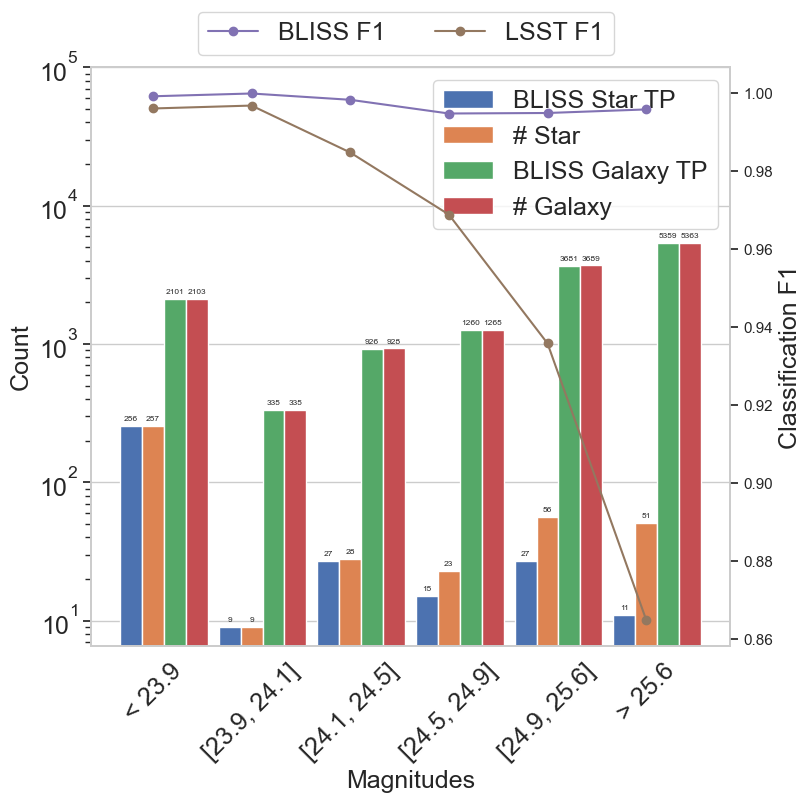

In [6]:
fig, ax = plot(bliss_internal_states,
               lsst_internal_states,
               bin_cutoffs=bin_cutoffs)
fig.savefig(output_dir / "classification_acc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

In [7]:
def separate_plot(bliss_internal_states,
         lsst_internal_states,
         bin_cutoffs):
    xlabels = (
        ["[< " + str(bin_cutoffs[0]) + "]"]
        + [f"[{bin_cutoffs[i]}, {bin_cutoffs[i + 1]}]" for i in range(len(bin_cutoffs) - 1)]
        + ["> " + str(bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig1, ax1 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax1.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax1.bar_label(rects, padding=3, fontsize=9)
        multiplier += 1

    ax1.set_ylabel("Count", fontsize=NoteBookVariables.font_size)
    ax1.set_xlabel("Magnitudes", fontsize=NoteBookVariables.font_size)
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(xlabels, rotation=45)
    ax1.tick_params(labelsize=NoteBookVariables.font_size)
    ax1.set_yscale("log")
    ax1.set_ylim(top=1e5)
    ax1.grid(visible=False, axis="x")
    ax1.legend(loc="upper right", fontsize=NoteBookVariables.font_size)

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    fig2, ax2 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    
    ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[0],
        label=f"BLISS galaxy F1",
    )
    ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[2],
        label=f"LSST galaxy F1",
    )
    
    ax2.set_ylabel("Classification F1", fontsize=NoteBookVariables.font_size)
    ax2.set_xlabel("Magnitudes", fontsize=NoteBookVariables.font_size)
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(xlabels, rotation=45)
    ax2.tick_params(labelsize=NoteBookVariables.font_size)
    ax2.grid(visible=False, axis="x")
    ax2.legend(fontsize=NoteBookVariables.font_size)


    fig3, ax3 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    
    ax3.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=False),
        "-o",
        color=color_list[0],
        label=f"BLISS star F1",
    )
    ax3.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=False),
        "-o",
        color=color_list[2],
        label=f"LSST star F1",
    )
    
    ax3.set_ylabel("Classification F1", fontsize=NoteBookVariables.font_size)
    ax3.set_xlabel("Magnitudes", fontsize=NoteBookVariables.font_size)
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(xlabels, rotation=45)
    ax3.tick_params(labelsize=NoteBookVariables.font_size)
    ax3.grid(visible=False, axis="x")
    ax3.legend(fontsize=NoteBookVariables.font_size)


    return fig1, fig2, fig3

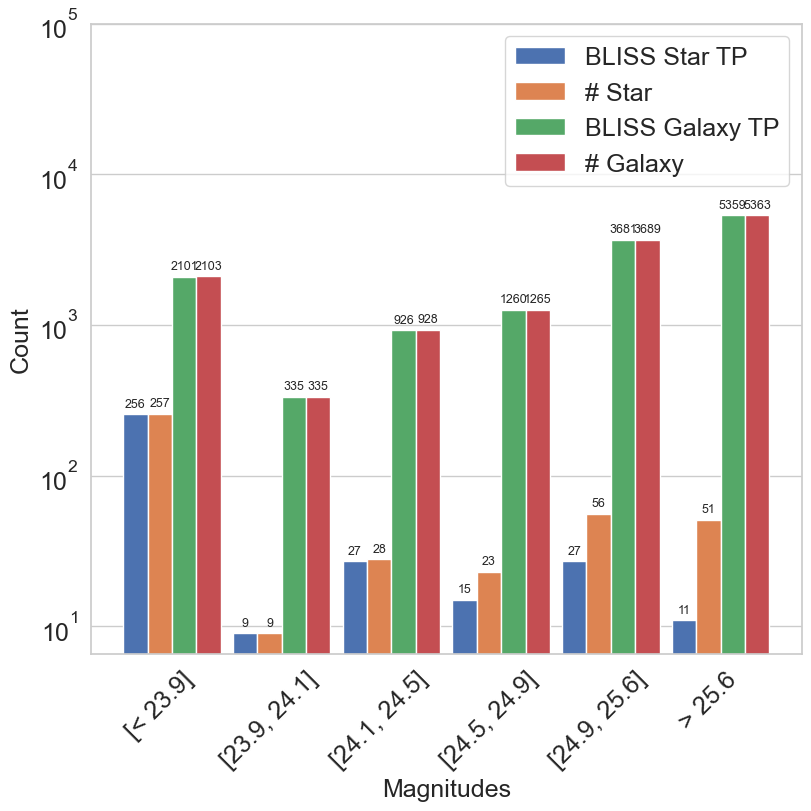

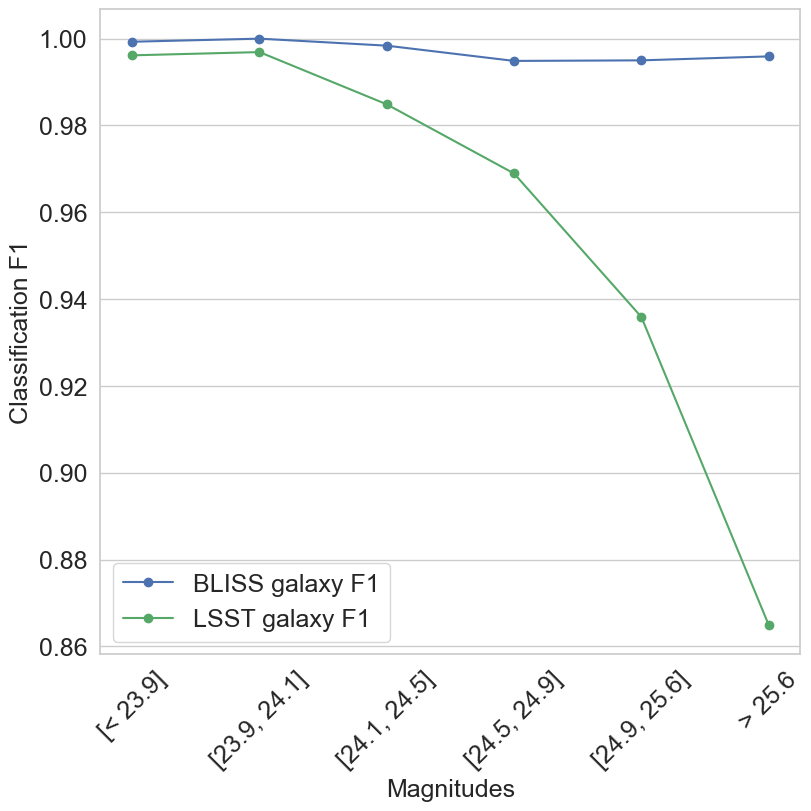

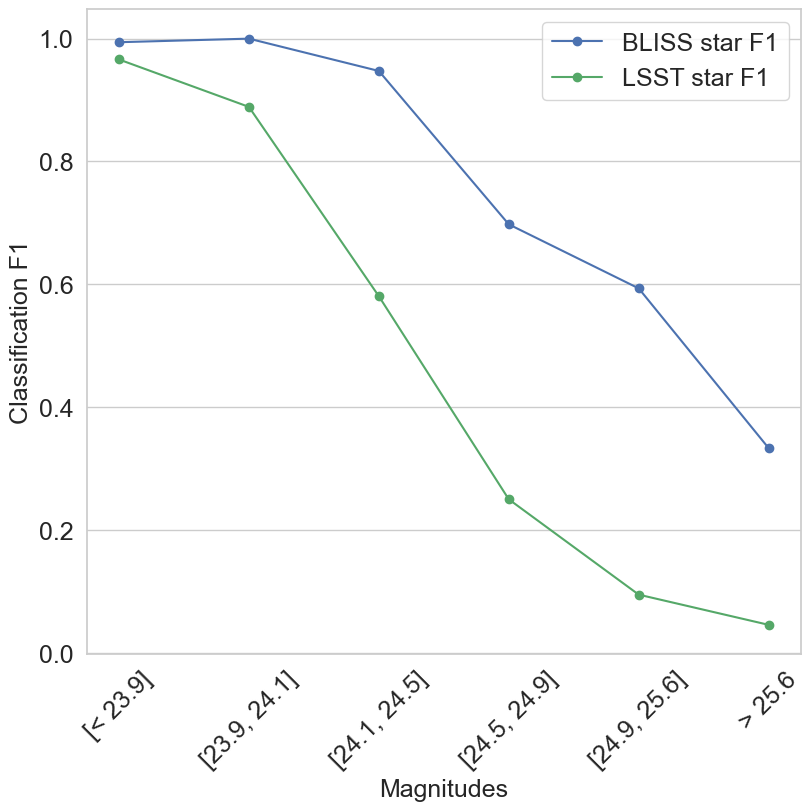

In [8]:
fig1, fig2, fig3 = separate_plot(bliss_internal_states,
                                    lsst_internal_states,
                                    bin_cutoffs=bin_cutoffs)
fig1.savefig(output_dir / "classification_acc_tp.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig1.show()

fig2.savefig(output_dir / "classification_galaxy_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig2.show()

fig3.savefig(output_dir / "classification_star_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig3.show()

In [9]:
def acc_wrt_thresholds(true_cls, est_probs, thredsholds):
    acc = torch.zeros(len(thredsholds))
    for i, threshold in enumerate(thredsholds):
        est_cls = est_probs >= threshold
        acc[i] = (est_cls[true_cls]).sum() / true_cls.sum()
    return acc

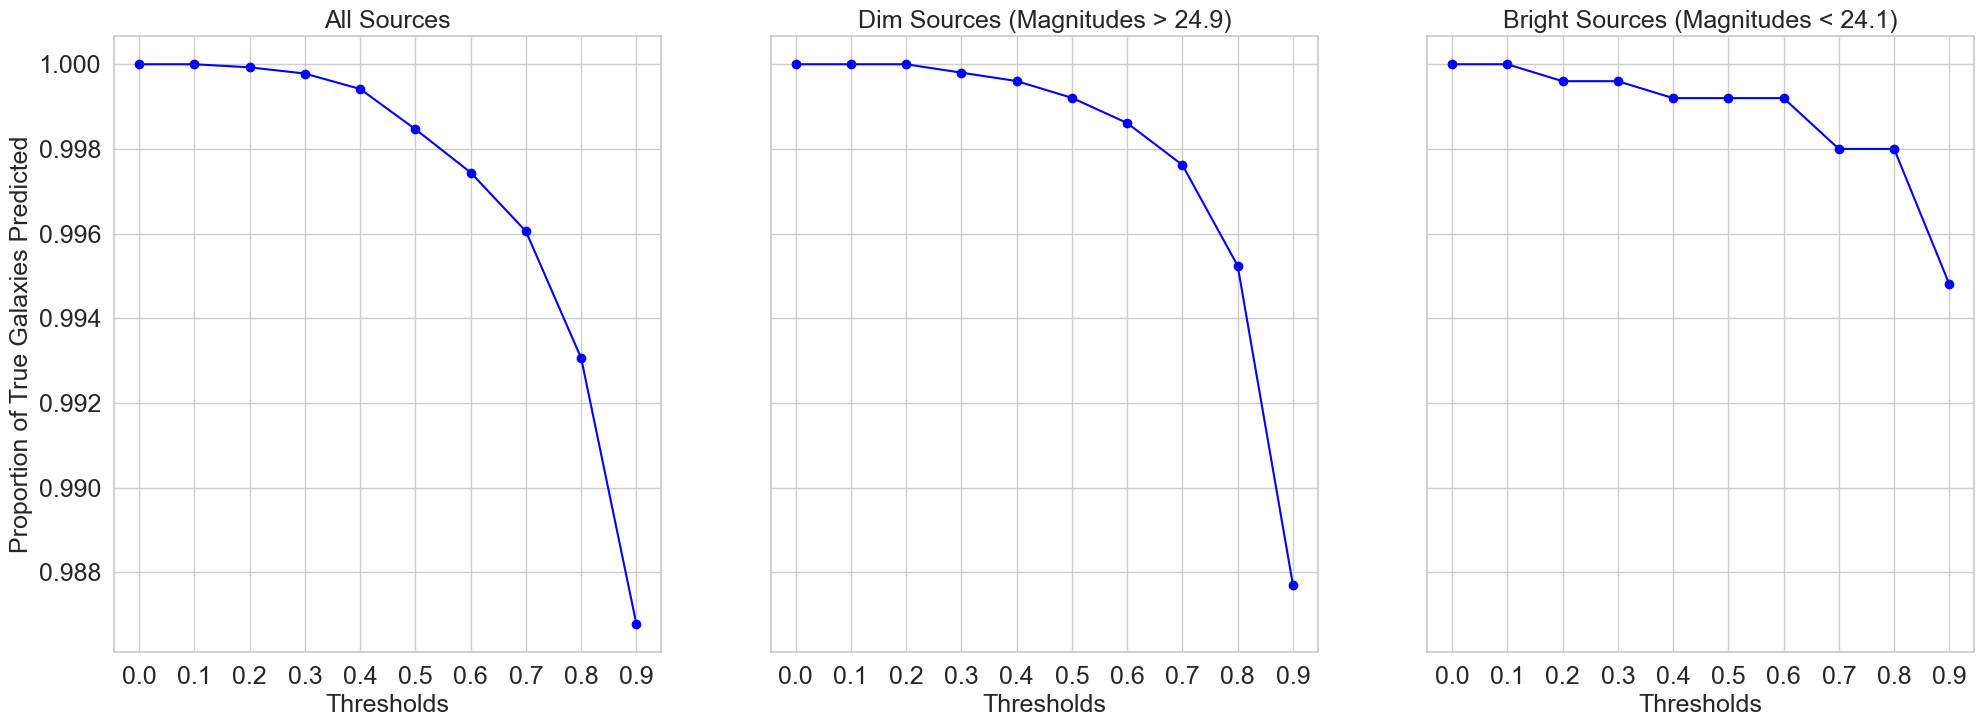

In [10]:
thresholds = [i / 100 for i in range(0, 100, 10)]

bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])

true_galaxy = (test_image_cat["source_type"][0, bliss_matching[0].tolist(), 0] == 1)
true_galaxy_fluxes = test_image_cat["galaxy_fluxes"][0, bliss_matching[0].tolist(), 2]
est_galaxy_probs = bliss_full_cat["source_type_probs"][0, bliss_matching[1].tolist(), 1]

fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(NoteBookVariables.figsize[0] * 3, NoteBookVariables.figsize[1]),
                         sharey="row")
x = list(range(len(thresholds)))
total_acc = acc_wrt_thresholds(true_galaxy, est_galaxy_probs, thresholds)
axes[0].plot(x, total_acc, "-o", color="blue")
axes[0].set_xlabel("Thresholds", fontsize=NoteBookVariables.font_size)
axes[0].set_xticks(x)
axes[0].set_xticklabels(thresholds)
axes[0].tick_params(labelsize=NoteBookVariables.font_size)
axes[0].set_title("All Sources", fontdict={"fontsize": NoteBookVariables.font_size})
axes[0].set_ylabel("Proportion of True Galaxies Predicted", fontsize=NoteBookVariables.font_size)

dim_filter = true_galaxy_fluxes < 200
dim_acc = acc_wrt_thresholds(true_galaxy[dim_filter], est_galaxy_probs[dim_filter], thresholds)
axes[1].plot(x, dim_acc, "-o", color="blue")
axes[1].set_xlabel("Thresholds", fontsize=NoteBookVariables.font_size)
axes[1].set_xticks(x)
axes[1].set_xticklabels(thresholds)
axes[1].tick_params(labelsize=NoteBookVariables.font_size)
axes[1].set_title("Dim Sources (Magnitudes > 24.9)", fontdict={"fontsize": NoteBookVariables.font_size})

bright_filter = true_galaxy_fluxes > 800
bright_acc = acc_wrt_thresholds(true_galaxy[bright_filter], est_galaxy_probs[bright_filter], thresholds)
axes[2].plot(x, bright_acc, "-o", color="blue")
axes[2].set_xlabel("Thresholds", fontsize=NoteBookVariables.font_size)
axes[2].set_xticks(x)
axes[2].set_xticklabels(thresholds)
axes[2].tick_params(labelsize=NoteBookVariables.font_size)
axes[2].set_title("Bright Sources (Magnitudes < 24.1)", fontdict={"fontsize": NoteBookVariables.font_size})

fig.savefig(output_dir / "classification_thresholds_plot.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

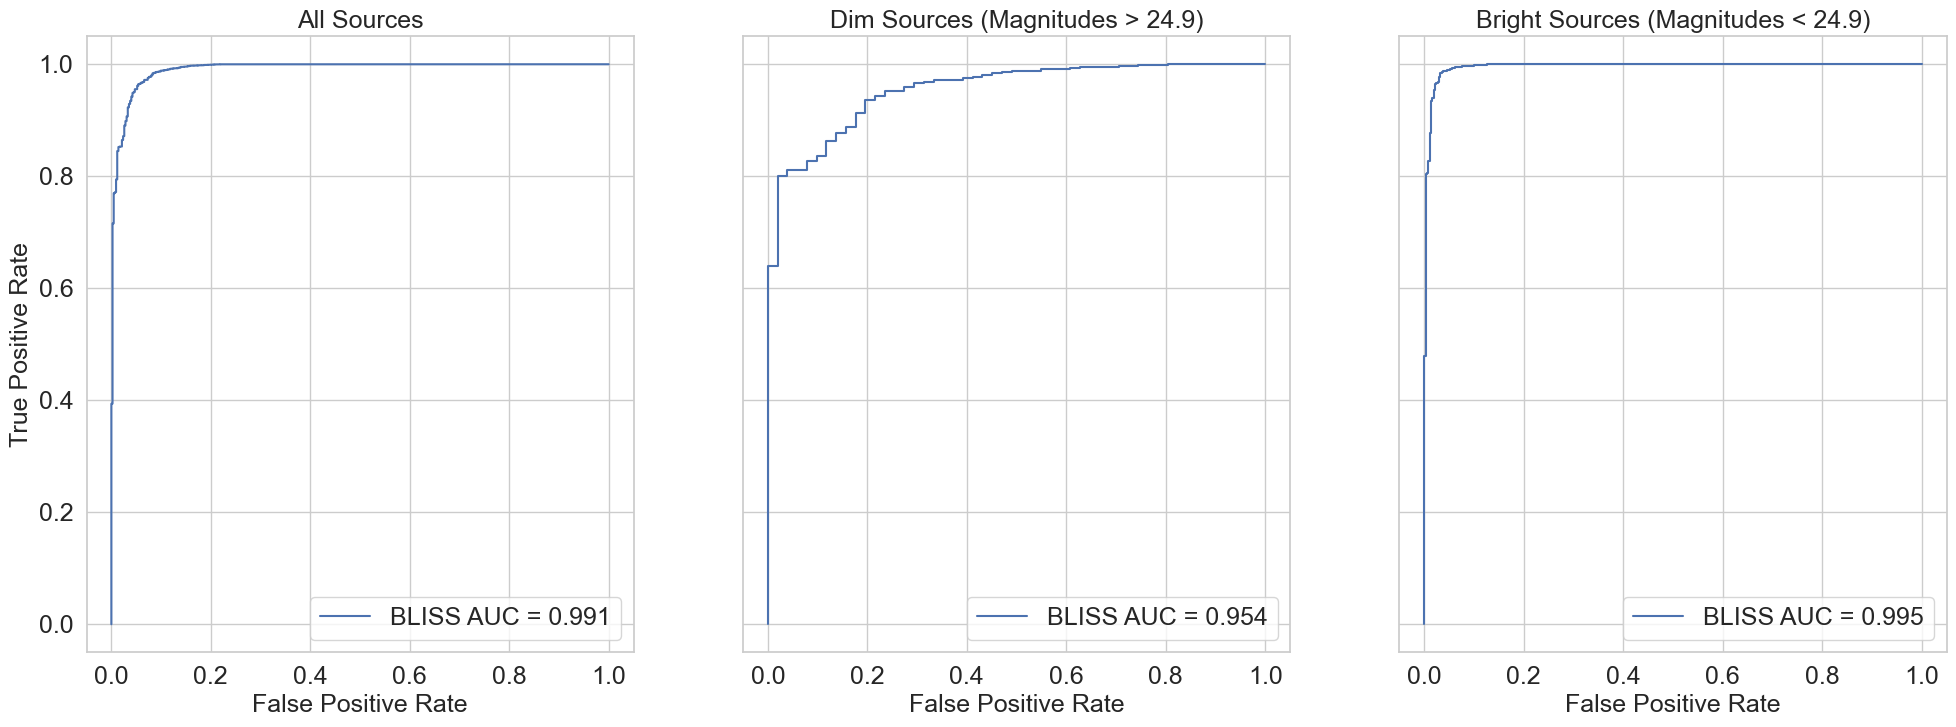

In [18]:
bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])

true_galaxy = (test_image_cat["source_type"][0, bliss_matching[0].tolist(), 0] == 1)
true_galaxy_fluxes = test_image_cat["galaxy_fluxes"][0, bliss_matching[0].tolist(), 2]
est_galaxy_probs = bliss_full_cat["source_type_probs"][0, bliss_matching[1].tolist(), 1]

fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(NoteBookVariables.figsize[0] * 3, NoteBookVariables.figsize[1]),
                         sharey="row")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_galaxy, est_galaxy_probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)
axes[0].plot(fpr, tpr, label=f"BLISS AUC ={roc_auc: .3f}")
axes[0].legend(fontsize=NoteBookVariables.font_size)
axes[0].set_xlabel("False Positive Rate", fontsize=NoteBookVariables.font_size)
axes[0].set_ylabel("True Positive Rate", fontsize=NoteBookVariables.font_size)
axes[0].set_title("All Sources", fontdict={"fontsize": NoteBookVariables.font_size})
axes[0].tick_params(labelsize=NoteBookVariables.font_size)

dim_filter = true_galaxy_fluxes < 200
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_galaxy[dim_filter], est_galaxy_probs[dim_filter])
roc_auc = sklearn.metrics.auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"BLISS AUC ={roc_auc: .3f}")
axes[1].legend(fontsize=NoteBookVariables.font_size)
axes[1].set_xlabel("False Positive Rate", fontsize=NoteBookVariables.font_size)
axes[1].set_title("Dim Sources (Magnitudes > 24.9)", fontdict={"fontsize": NoteBookVariables.font_size})
axes[1].tick_params(labelsize=NoteBookVariables.font_size)

bright_filter = true_galaxy_fluxes > 200
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_galaxy[bright_filter], est_galaxy_probs[bright_filter])
roc_auc = sklearn.metrics.auc(fpr, tpr)
axes[2].plot(fpr, tpr, label=f"BLISS AUC ={roc_auc: .3f}")
axes[2].legend(fontsize=NoteBookVariables.font_size)
axes[2].set_xlabel("False Positive Rate", fontsize=NoteBookVariables.font_size)
axes[2].set_title("Bright Sources (Magnitudes < 24.9)", fontdict={"fontsize": NoteBookVariables.font_size})
axes[2].tick_params(labelsize=NoteBookVariables.font_size)

fig.savefig(output_dir / "roc_plot.pdf", bbox_inches="tight")
fig.show()